In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# print(os.listdir("../input"))

import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats
from sklearn.model_selection import GridSearchCV
import statistics
from sklearn import metrics

In [6]:
cd = os.getcwd()
full_path = cd + "\Titanic Survivors\\all\\"

In [7]:
df = pd.read_csv(full_path+"train.csv")
test_df =  pd.read_csv(full_path+"test.csv")

In [8]:
print("Total number of instance : ",len(df))
df.isna().sum()

Total number of instance :  891


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
df["Age"].fillna(df["Age"].mean(), inplace = True)
test_df["Age"].fillna(test_df["Age"].mean(), inplace = True)

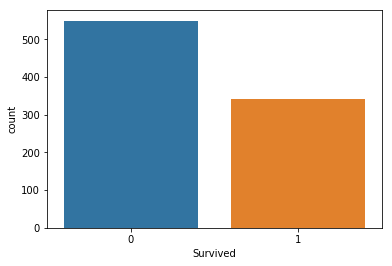

In [10]:
# checking class distribution
sns.countplot(x = "Survived", data = df)

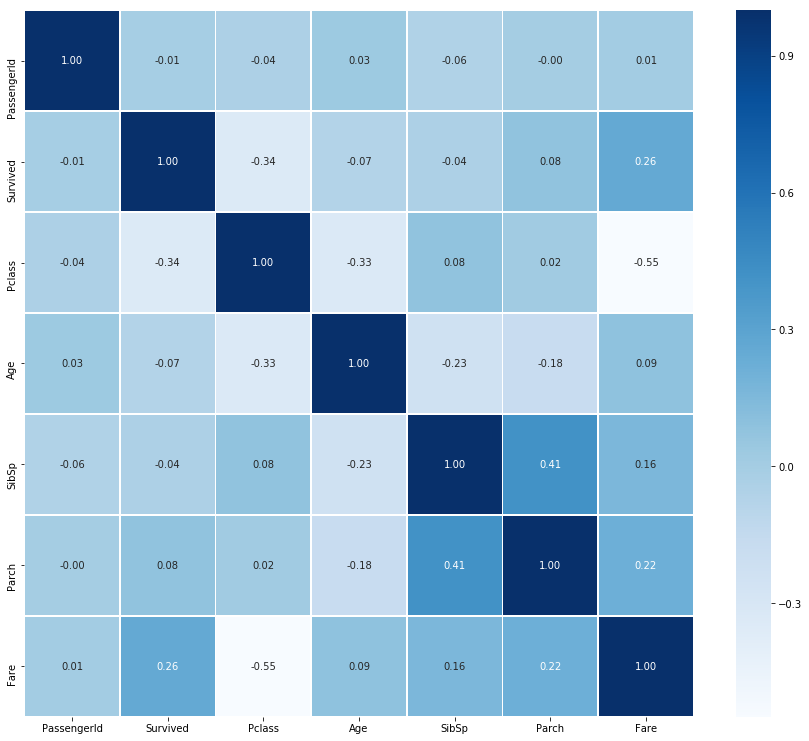

In [11]:
f,ax = plt.subplots(figsize=(15, 13))
sns.heatmap(df.corr(), annot=True, cmap = "Blues", linewidths=.5, fmt= '.2f',ax = ax)
plt.show()

In [12]:
df_survived = df[df["Survived"]==1]
df_notsurvived = df[df["Survived"]==0]

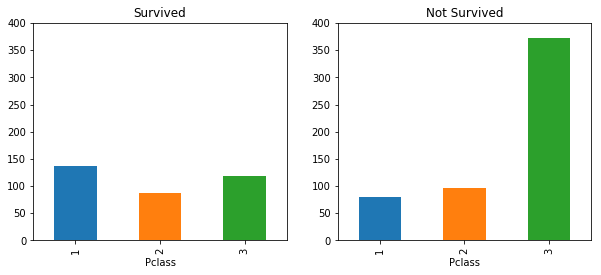

In [13]:
gb_pclass_surv = df_survived.groupby("Pclass")["Survived"].sum()
gb_pclass_notsurv = df_notsurvived.groupby("Pclass")["Survived"].count()


fig = plt.figure(figsize = (10,4))
f1 = fig.add_subplot(1, 2, 1)
f1.set_ylim([0,400])
f2 = fig.add_subplot(1,2,2)
f2.set_ylim([0,400])
gb_pclass_surv.plot(kind= "bar", title = "Survived", ax = f1)
gb_pclass_notsurv.plot(kind= "bar", title = "Not Survived", ax = f2);

The plots above shows that most of the passengers holding 3rd Class tickets didn't survive. where on the other hand passengers with Pclass 1 survived more. Passengers with Pclass 2 survived and didn't survive equally.

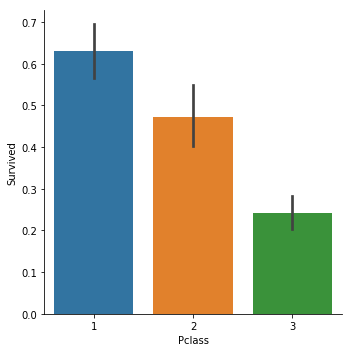

In [14]:
sns.catplot(x = 'Pclass', y = "Survived", data = df, kind = "bar");

This shows that people with higher socioeconomic status were able to survive more than the people with lower socioeconomic status. As the Pclass feature gives important information about the survival rate we will convert them to dummy columns. We will also be doing the samed for Embarked column.

In [15]:
pclass_dum = pd.get_dummies(df["Pclass"])
test_pclass_dum = pd.get_dummies(test_df["Pclass"])

df = pd.concat([df, pclass_dum], axis = 1)
test_df = pd.concat([test_df, test_pclass_dum], axis = 1)

In [16]:
df.rename({1:"pclass1", 2:"pclass2", 3:"pclass3"}, axis = 1, inplace = True)
test_df.rename({1:"pclass1", 2:"pclass2", 3:"pclass3"}, axis = 1, inplace = True)

df.drop(["Pclass"], axis = 1, inplace = True)
test_df.drop(["Pclass"], axis = 1, inplace = True)

In [17]:
df = pd.concat([df.iloc[:, :-1], 
        pd.get_dummies(df.loc[:, 'Embarked'])],
        axis=1)
# print(X_train)

test_df = pd.concat([test_df.iloc[:, :-1], 
        pd.get_dummies(test_df.loc[:, 'Embarked'])],
        axis=1)

Removing the irrelevant features.

In [18]:
df.drop("PassengerId", axis = 1, inplace = True)
test_df.drop("PassengerId", axis = 1, inplace = True)

Converting the character or string values to numbers.

In [19]:
gender = {'female': 1, 'male':2}
df['Sex'] = df['Sex'].apply(lambda x: gender[x])
test_df['Sex'] = test_df['Sex'].apply(lambda x: gender[x])

Creating new features

In [20]:
df["n_fam_mem"] = df["SibSp"] + df["Parch"] + 1
test_df["n_fam_mem"] = df["SibSp"] + df["Parch"] + 1

In [21]:
def create_family_ranges(df):
    familysize = []
    for members in df["n_fam_mem"]:
        if members == 1:
            familysize.append(1)
        elif members == 2:
            familysize.append(2)
        elif members>2 and members<=4:
            familysize.append(3)
        elif members > 4:
            familysize.append(4)
    return familysize

famsize = create_family_ranges(df)
df["familysize"] = famsize

test_famsize = create_family_ranges(test_df)
test_df["familysize"] = test_famsize

In [22]:
# df

In [23]:
fsizedummies = pd.get_dummies(df["familysize"])
test_fsizedummies = pd.get_dummies(test_df["familysize"])

df = pd.concat([df, fsizedummies], axis = 1)
test_df = pd.concat([test_df, test_fsizedummies], axis = 1)

In [24]:
df.rename({1:"fam_single",2:"fam_small",3:"fam_medium", 4:"fam_big"}, axis = 1, inplace = True)
test_df.rename({1:"fam_single",2:"fam_small",3:"fam_medium", 4:"fam_big"}, axis = 1, inplace = True)

In [25]:
# df

In [26]:
def age_to_int(df):
    agelist = df["Age"].values.tolist()
    for i in range(len(agelist)):
        if agelist[i] < 14 and agelist[i] >= 0: #children
            agelist[i] = 0
        elif agelist[i] >= 14 and agelist[i] < 25: #youth
            agelist[i] = 1
        elif agelist[i]>=25 and agelist[i]<60:# adult
            agelist[i] = 2
        elif agelist[i]>=60:# senior
            agelist[i] = 3
    ageint = pd.DataFrame(agelist)
    return ageint

In [27]:
ageint = age_to_int(df)
df["Ageint"] = ageint
df.drop("Age", axis = 1, inplace = True)

test_ageint = age_to_int(test_df)
test_df["Ageint"] = test_ageint
test_df.drop("Age", axis = 1, inplace = True)

In [28]:
test_df["Fare"].fillna(test_df["Fare"].median(), inplace = True)

df["actual_fare"] = df["Fare"]/df["n_fam_mem"]

test_df["actual_fare"] = test_df["Fare"]/test_df["n_fam_mem"]


In [29]:
def conv_fare_ranges(df): 
    fare_ranges = []
    for fare in df["actual_fare"]:
        if fare < 7:
            fare_ranges.append(0)
        elif fare >=7 and fare < 14:
            fare_ranges.append(1)
        elif fare >=14 and fare < 30:
            fare_ranges.append(2)
        elif fare >=30 and fare < 50:
            fare_ranges.append(3)
        elif fare >=50:
            fare_ranges.append(4)
    return fare_ranges
        
fare_ranges = conv_fare_ranges(df)
df["fare_ranges"] = fare_ranges

test_fare_ranges = conv_fare_ranges(test_df)
test_df["fare_ranges"] = test_fare_ranges

In [30]:
df["Cabin"].fillna("unknown", inplace = True)
test_df["Cabin"].fillna("unknown", inplace = True)


In [31]:
df.drop(["Ticket"], axis = 1, inplace = True)
test_df.drop(["Ticket"], axis = 1, inplace = True)

In [32]:
def clean_cabin(df):
    cabin_list = []
    for i in df["Cabin"]:
        cabin = "unknown"
        if i != "unknown":
            cabin = i[0]
        cabin_list.append(cabin)
    return cabin_list

cabins = clean_cabin(df)
test_cabins = clean_cabin(test_df)

df.drop(["Cabin"], axis = 1, inplace = True)
test_df.drop(["Cabin"], axis = 1, inplace = True)

df["cabintype"] = cabins
test_df["cabintype"] = test_cabins

In [33]:
df.drop(["cabintype"], axis = 1, inplace = True)
test_df.drop(["cabintype"], axis = 1, inplace = True)

In [34]:
df["Embarked"].fillna("S", inplace = True)
test_df["Embarked"].fillna("S", inplace = True)

df["Embarked"].replace(["S","C","Q"],[0,1,2], inplace = True)
test_df["Embarked"].replace(["S","C","Q"],[0,1,2], inplace = True)

In [35]:
def name_to_int(df):
    name = df["Name"].values.tolist()
    namelist = []
    for i in name:
        index = 1
        inew = i.split()
        if inew[0].endswith(","):
            index = 1
        elif inew[1].endswith(","):
            index = 2
        elif inew[2].endswith(","):
            index = 3
        namelist.append(inew[index])
        
    titlelist = []
    
    for i in range(len(namelist)): 
        if namelist[i] == "Lady.":
            titlelist.append("Lady.")
        elif namelist[i] == "Ms.":
            titlelist.append("Ms.")
        elif namelist[i] == "Miss.":
            titlelist.append("Miss.")
        elif namelist[i] == "Dr.":
            titlelist.append("Dr.")
        elif namelist[i] == "Mr.":
            titlelist.append("Mr.")
        elif namelist[i] == "Jonkheer.":
            titlelist.append("Jonkheer.")
        elif namelist[i] == "Col.":
            titlelist.append("Col.")
        elif namelist[i] == "Mrs.":
            titlelist.append("Mrs")
        elif namelist[i] == "Sir.":
            titlelist.append("Sir.")
        elif namelist[i] == "Mlle.":
            titlelist.append("Mlle.")
        elif namelist[i] == "Capt.":
            titlelist.append("Capt.")
        elif namelist[i] == "the":
            titlelist.append("the")
        elif namelist[i] == "Don.":
            titlelist.append("Don.")
        elif namelist[i] == "Master.":
            titlelist.append("Master.")
        elif namelist[i] == "Rev.":
            titlelist.append("Rev.")
        elif namelist[i] == "Mme.":
            titlelist.append("Mme.")
        elif namelist[i] == "Major.":
            titlelist.append("Major.")
        else:
            titlelist.append("sometitle")
    return titlelist

In [36]:
titlelist = name_to_int(df)
df["titles"] = titlelist
df["titles"].value_counts()
testtitlelist = name_to_int(test_df)
test_df["titles"] = testtitlelist
df["titles"].value_counts()

Mr.          517
Miss.        182
Mrs          125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Col.           2
Major.         2
Lady.          1
Jonkheer.      1
Ms.            1
Sir.           1
Capt.          1
Don.           1
the            1
Mme.           1
Name: titles, dtype: int64

In [37]:
df["titles"].replace(["Jonkheer.","the","Don.","Capt.","Sir.","Col.","Major.","Dr.","Rev."], "sometitle", inplace = True)
test_df["titles"].replace(["Jonkheer.","the","Don.","Capt.","Sir.","Col.","Major.","Dr.","Rev."],"sometitle", inplace = True)

df["titles"].replace(["Mlle.","Lady.","Mme.","Ms."],"Miss.", inplace = True)
test_df["titles"].replace(["Mlle.","Lady.","Mme.","Ms."],"Miss.", inplace = True)


In [38]:
df["titles"].replace(["Mr.", "Miss.", "Mrs", "Master.","sometitle"],[0,1,2,3,4], inplace = True)
df["titles"].astype("int64")

test_df["titles"].replace(["Mr.", "Miss.", "Mrs", "Master.", "sometitle"],[0,1,2,3,4], inplace = True)
test_df["titles"].astype("int64")

df.drop(["Name"], axis = 1, inplace = True)
test_df.drop(["Name"], axis = 1, inplace = True)

In [39]:
# df

In [40]:
labels = df["Survived"]
data = df.drop("Survived", axis = 1)

In [41]:
data

,Sex,SibSp,Parch,Fare,Embarked,pclass1,pclass2,C,Q,S,n_fam_mem,familysize,fam_single,fam_small,fam_medium,fam_big,Ageint,actual_fare,fare_ranges,titles
0,2,1,0,7.2500,0,0,0,0,0,1,2,2,0,1,0,0,1,3.625000,0,0
1,1,1,0,71.2833,1,1,0,1,0,0,2,2,0,1,0,0,2,35.641650,3,2
2,1,0,0,7.9250,0,0,0,0,0,1,1,1,1,0,0,0,2,7.925000,1,1
3,1,1,0,53.1000,0,1,0,0,0,1,2,2,0,1,0,0,2,26.550000,2,2
4,2,0,0,8.0500,0,0,0,0,0,1,1,1,1,0,0,0,2,8.050000,1,0
5,2,0,0,8.4583,2,0,0,0,1,0,1,1,1,0,0,0,2,8.458300,1,0
6,2,0,0,51.8625,0,1,0,0,0,1,1,1,1,0,0,0,2,51.862500,4,0
7,2,3,1,21.0750,0,0,0,0,0,1,5,4,0,0,0,1,0,4.215000,0,3
8,1,0,2,11.1333,0,0,0,0,0,1,3,3,0,0,1,0,2,3.711100,0,2
9,1,1,0,30.0708,1,0,1,1,0,0,2,2,0,1,0,0,1,15.035400,2,2


In [42]:
final_clf = None
clf_names = ["Logistic Regression", "KNN(3)", "KNN(5)", "Linear Discriminant Analysis", "Decision Tree Classifier",
            "Gradient Boosting Classifier", "Support Vector Machine"]

In [43]:
classifiers = []
scores = []
for i in range(10):
    
    X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.1)
    tempscores = []
    
    # logistic Regression
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, Y_train)
    tempscores.append((lr_clf.score(X_test, Y_test))*100)
    
    # KNN n_neighbors = 3
    knn3_clf = KNeighborsClassifier(n_neighbors = 3)
    knn3_clf.fit(X_train, Y_train)
    tempscores.append((knn3_clf.score(X_test, Y_test))*100)

    # KNN n_neighbors = 5
    knn5_clf = KNeighborsClassifier(n_neighbors = 5)
    knn5_clf.fit(X_train, Y_train)
    tempscores.append((knn5_clf.score(X_test, Y_test))*100)

    # Linear Discriminant Analysis
    lda_clf = LinearDiscriminantAnalysis()
    lda_clf.fit(X_train, Y_train)
    tempscores.append((lda_clf.score(X_test, Y_test))*100)

    # Decision Tree
    dt_clf = DecisionTreeClassifier()
    dt_clf.fit(X_train, Y_train)
    tempscores.append((dt_clf.score(X_test, Y_test))*100)

    # Gradient Boosting 
    gb_clf = GradientBoostingClassifier()
    gb_clf.fit(X_train, Y_train)
    tempscores.append((gb_clf.score(X_test, Y_test))*100)

    #SVM
    svm_clf = SVC(gamma = "scale")
    svm_clf.fit(X_train, Y_train)
    tempscores.append((svm_clf.score(X_test, Y_test))*100)
    
    scores.append(tempscores)

c:\users\sayali\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sayali\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\sayali\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sayali\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\sayali\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver w

In [44]:

scores = np.array(scores)
clfs = pd.DataFrame({"Classifier":clf_names})
clfs["iteration0"] = scores[0].T
clfs["iteration1"] = scores[1].T
clfs["iteration2"] = scores[2].T
clfs["iteration3"] = scores[3].T
clfs["iteration4"] = scores[4].T
clfs["iteration5"] = scores[5].T
clfs["iteration6"] = scores[6].T
clfs["iteration7"] = scores[7].T
clfs["iteration8"] = scores[8].T
clfs["iteration9"] = scores[9].T

means = clfs.mean(axis = 1)
means = means.values.tolist()

clfs["Average"] = means

In [45]:
clfs.set_index("Classifier", inplace = True)
print("Accuracies : ")
clfs["Average"].head(10)

Accuracies : 


Classifier
Logistic Regression             79.555556
KNN(3)                          76.555556
KNN(5)                          76.333333
Linear Discriminant Analysis    80.222222
Decision Tree Classifier        79.555556
Gradient Boosting Classifier    81.555556
Support Vector Machine          72.555556
Name: Average, dtype: float64

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [48]:
clf = LinearDiscriminantAnalysis()

In [49]:
clf.fit(data, labels)

c:\users\sayali\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [50]:
Z = clf.predict(test_df)

In [51]:
Actual_Class = pd.read_csv(full_path+"gender_submission.csv")

In [52]:
metrics.accuracy_score(Z, np.asarray(Actual_Class['Survived']))

0.937799043062201